Linear Regression Model for Tourism Data 

In [42]:
import os
import joblib

os.getcwd()


'/home/clif_lastrophysicien/ELO2_LAPERLE_HT/4_data_analysis'

Step 1: Understanding the Data

In [43]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings

warnings.filterwarnings("ignore")

# Set display options
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)


In [44]:
# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")


In [45]:

# Load the data
df = pd.read_csv('UN_tourism_caribbean_countries_cleaned.csv')

# Method 1: Filter specific years
df_filtered = df[~df['year'].isin([2023, 2024])]

# Method 2: Keep only years ≤ 2022
df_filtered = df[df['year'] <= 2022]

# Method 3: Use an inverse condition
df_filtered = df[(df['year'] != 2023) & (df['year'] != 2024)]

print(f"Original size: {df.shape}")
print(f"Filtered size: {df_filtered.shape}")
print(f"Remaining years: {df_filtered['year'].unique()[:10]}...")

Original size: (3025, 6)
Filtered size: (3005, 6)
Remaining years: [1995 1996 1997 1998 1999 2000 2001 2002 2003 2004]...


2: Loading and Exploring the Data

In [46]:
# Load the dataset
df = pd.read_csv("UN_tourism_caribbean_countries_cleaned.csv")

# Display basic information
print("=== DATASET INFORMATION ===")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print("\nFirst 5 rows:")
print(df.head())

print("\n=== BASIC STATISTICS ===")
print(df.describe())

print("\n=== UNIQUE VALUES ===")
print(f"Visitor types: {df['type_of_visitors'].unique()}")
print(f"Number of countries: {df['country_receiving'].nunique()}")
print(f"Years range: {df['year'].min()} to {df['year'].max()}")


=== DATASET INFORMATION ===
Shape: (3025, 6)

Columns: ['type_of_visitors', 'country_receiving', 'where_tourist_from', 'year', 'number_of_tourist', 'unit']

Data Types:
type_of_visitors       object
country_receiving      object
where_tourist_from     object
year                    int64
number_of_tourist     float64
unit                   object
dtype: object

Missing Values:
type_of_visitors      0
country_receiving     0
where_tourist_from    0
year                  0
number_of_tourist     0
unit                  0
dtype: int64

First 5 rows:
  type_of_visitors    country_receiving where_tourist_from  year  \
0    excursionists  Antigua and Barbuda              World  1995   
1    excursionists  Antigua and Barbuda              World  1996   
2    excursionists  Antigua and Barbuda              World  1997   
3    excursionists  Antigua and Barbuda              World  1998   
4    excursionists  Antigua and Barbuda              World  1999   

   number_of_tourist            unit  


 Understanding the Data Structure

  The dataset contains:

  type_of_visitors: Type of visitors (tourists, excursionists, visitors_total)

  country_receiving: Destination country

  where_tourist_from: Origin (all are "World")

  year: Year of data

  number_of_tourist: Number of visitors (in thousand trips)

  unit: Measurement unit (thousand trips)

3. Data Preprocessing

=== HANDLING MISSING VALUES ===
Missing values before cleaning: 0
Filtering out years 2023 and 2024...
Missing values after cleaning: 0
Dataset now includes years: 1995 to 2022

=== ENCODING CATEGORICAL VARIABLES ===
Encoded 30 countries
Encoded visitor types: ['excursionists' 'tourists' 'visitors_total']

=== FEATURE ENGINEERING ===
New features created: decade, post_2000, post_2010, covid_period, year_since_1995, post_covid
Current year range: 1995 - 2022

=== DATA DISTRIBUTION ===


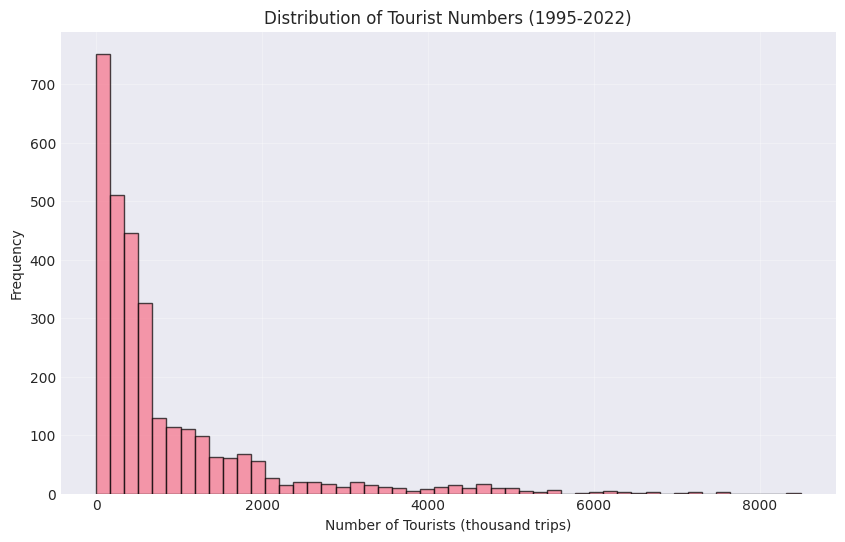

Skewness: 2.70
Data range: 0.1 - 8488.9
Mean: 811.1, Median: 424.0


In [ ]:
# Step 3.1: Handle missing values
print("=== HANDLING MISSING VALUES ===")
print(f"Missing values before cleaning: {df.isnull().sum().sum()}")

# Since this is time series data, we'll fill missing values with forward/backward fill
df["number_of_tourist"] = (
    df["number_of_tourist"].fillna(method="ffill").fillna(method="bfill")
)

print(f"Missing values after cleaning: {df.isnull().sum().sum()}")

# Step 3.2: Convert categorical variables to numerical
print("\n=== ENCODING CATEGORICAL VARIABLES ===")

# Create label encoders
country_encoder = LabelEncoder()
visitor_type_encoder = LabelEncoder()

# Encode categorical variables
df["country_encoded"] = country_encoder.fit_transform(df["country_receiving"])
df["visitor_type_encoded"] = visitor_type_encoder.fit_transform(df["type_of_visitors"])

print(f"Encoded {len(country_encoder.classes_)} countries")
print(f"Encoded visitor types: {visitor_type_encoder.classes_}")

# Step 3.3: Feature Engineering
print("\n=== FEATURE ENGINEERING ===")

# Create additional features that might be useful
df["decade"] = (df["year"] // 10) * 10
df["post_2000"] = (df["year"] > 2000).astype(int)
df["post_2010"] = (df["year"] > 2010).astype(int)

# COVID-19 impact indicator (2020-2021)
df["covid_period"] = ((df["year"] >= 2020) & (df["year"] <= 2021)).astype(int)

print("New features created: decade, post_2000, post_2010, covid_period")

# Step 3.4: Check data distribution
print("\n=== DATA DISTRIBUTION ===")
plt.figure(figsize=(10, 6))
plt.hist(df["number_of_tourist"], bins=50, edgecolor="black", alpha=0.7)
plt.title("Distribution of Tourist Numbers")
plt.xlabel("Number of Tourists (thousand trips)")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.show()

print(f"Skewness: {df['number_of_tourist'].skew():.2f}")


4. Exploratory Data Analysis (EDA)

=== CORRELATION ANALYSIS (1995-2022) ===
Analyzing correlations for years 1995-2022


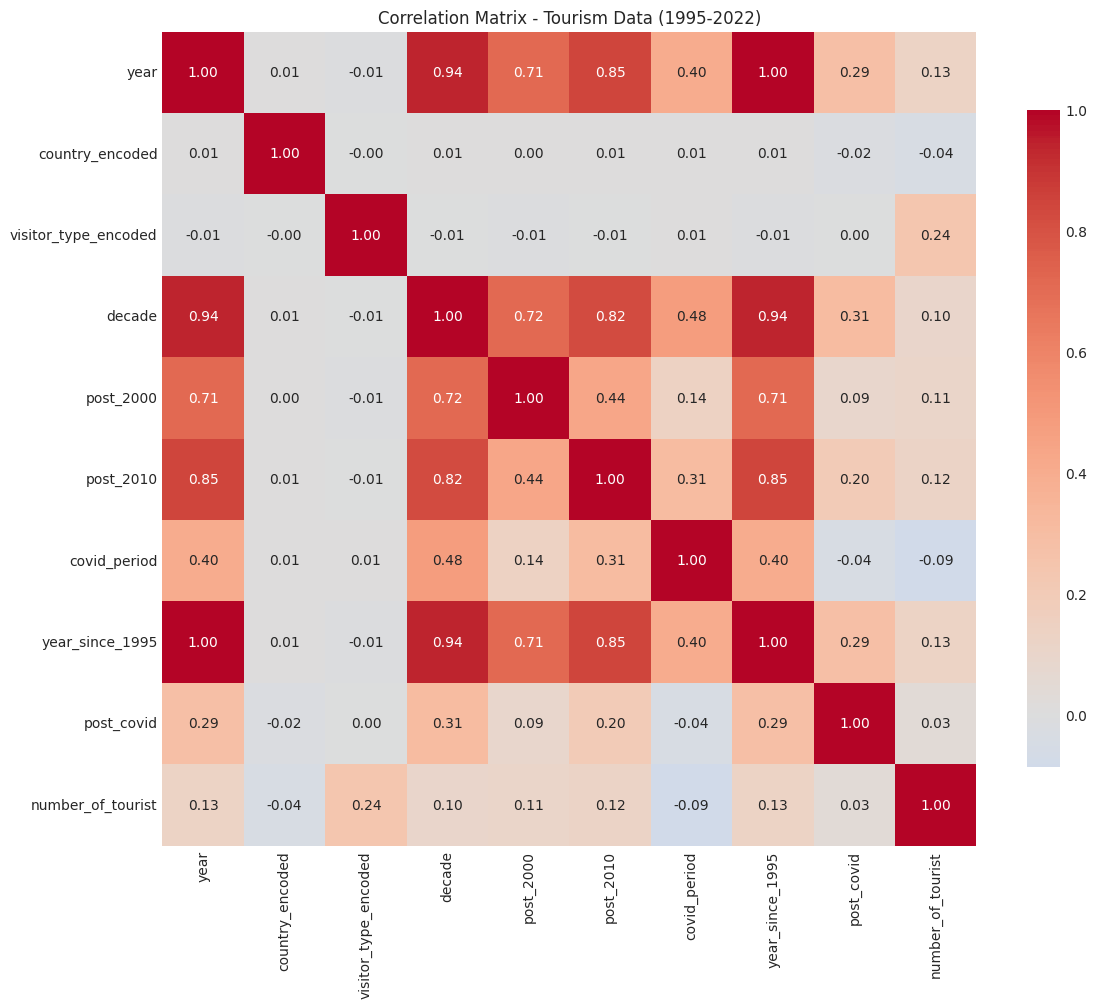


Key correlations with tourist numbers:
  visitor_type_encoded: 0.237
  year: 0.127
  year_since_1995: 0.127
  post_2010: 0.122
  post_2000: 0.111
  decade: 0.098
  post_covid: 0.033
  country_encoded: -0.041
  covid_period: -0.087

=== TIME SERIES ANALYSIS (1995-2022) ===


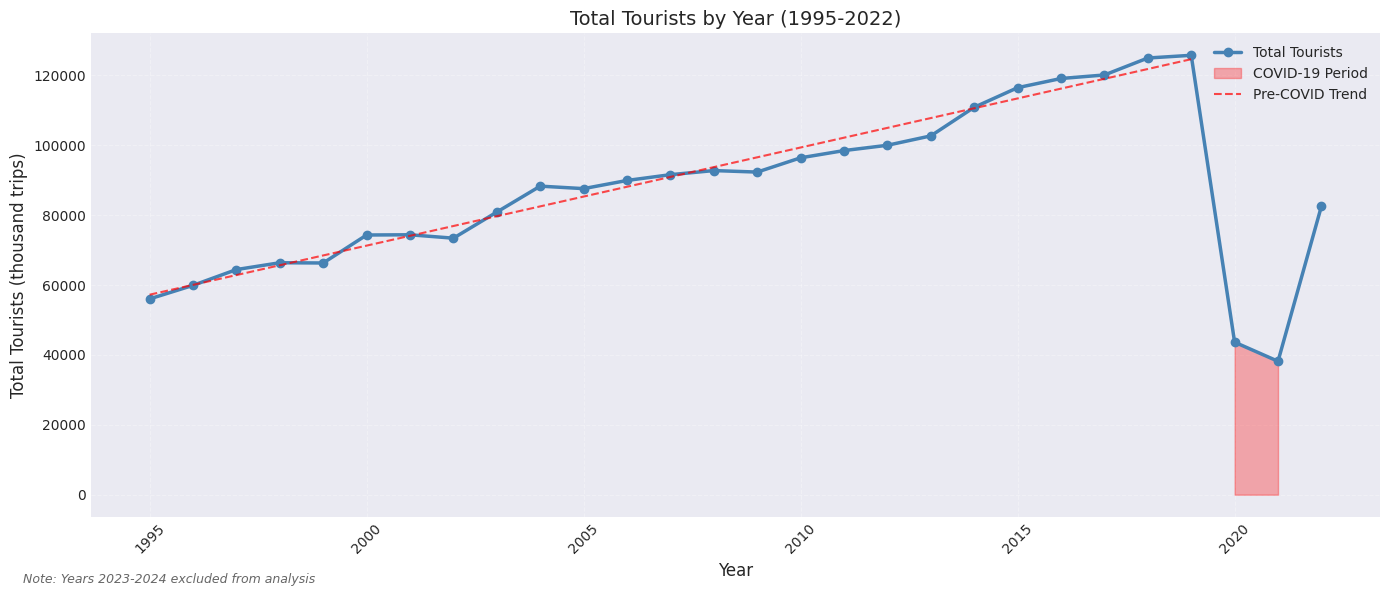


Year-over-year growth statistics:
  Average growth: 4.5%
  Max growth: 116.2% (year 2022)
  Min growth: -65.3% (year 2020)

=== VISITOR TYPE ANALYSIS (1995-2022) ===
Visitor Type Statistics (1995-2022):
                 Average    Total  Records Std_Dev  Minimum   Maximum
type_of_visitors                                                     
excursionists        623  899,371     1444     776      0.1  5548.600
tourists             679  540,187      795   1,048      1.6  7163.414
visitors_total     1,303  997,938      766   1,464      1.6  8488.856


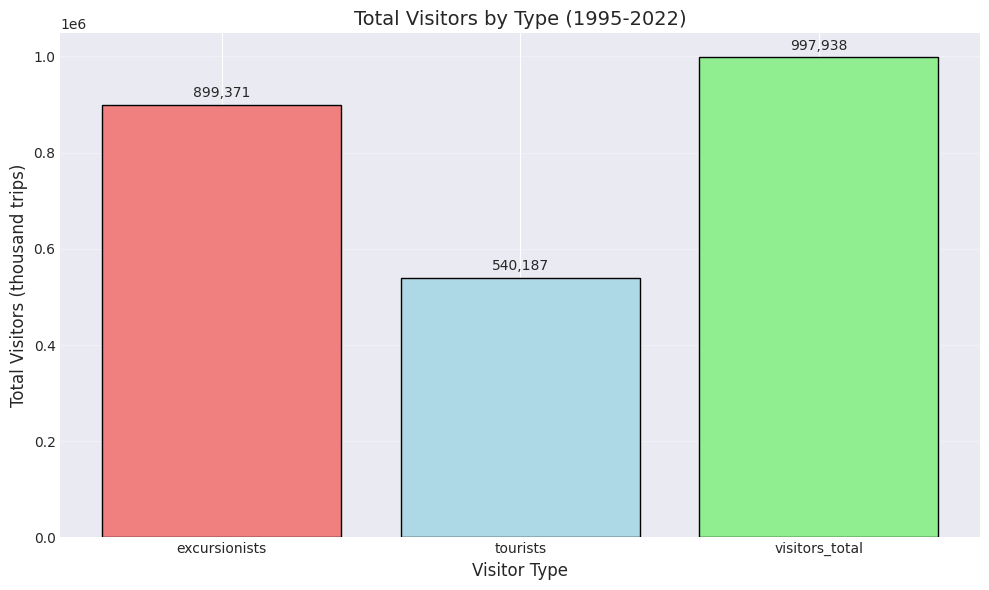


Visitor Type Distribution (%):
  excursionists: 36.9%
  tourists: 22.2%
  visitors_total: 40.9%


In [51]:
# Step 4.1: Correlation Analysis (1995-2022 data)
print("=== CORRELATION ANALYSIS (1995-2022) ===")

# Select numerical features for correlation (year range now limited to 1995-2022)
numerical_features = [
    "year", 
    "country_encoded", 
    "visitor_type_encoded", 
    "decade", 
    "post_2000", 
    "post_2010", 
    "covid_period",
    "year_since_1995",
    "post_covid"
]

print(f"Analyzing correlations for years {df['year'].min()}-{df['year'].max()}")

# Create correlation matrix
correlation_matrix = df[numerical_features + ["number_of_tourist"]].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, fmt=".2f", 
            square=True, cbar_kws={"shrink": 0.8})
plt.title(f"Correlation Matrix - Tourism Data ({df['year'].min()}-{df['year'].max()})")
plt.tight_layout()
plt.show()

# Highlight key correlations
print("\nKey correlations with tourist numbers:")
key_correlations = correlation_matrix["number_of_tourist"].sort_values(ascending=False)
for feature, corr_value in key_correlations.items():
    if feature != "number_of_tourist":  # Skip self-correlation
        print(f"  {feature}: {corr_value:.3f}")

# Step 4.2: Time Series Analysis (excluding 2023-2024)
print(f"\n=== TIME SERIES ANALYSIS ({df['year'].min()}-{df['year'].max()}) ===")

# Aggregate data by year
yearly_tourists = df.groupby("year")["number_of_tourist"].sum().reset_index()

plt.figure(figsize=(14, 6))

# Main time series plot
plt.plot(yearly_tourists["year"], yearly_tourists["number_of_tourist"], 
         marker="o", linewidth=2.5, markersize=6, color='steelblue', label='Total Tourists')

# Highlight COVID period
covid_years = yearly_tourists[(yearly_tourists["year"] >= 2020) & (yearly_tourists["year"] <= 2021)]
if not covid_years.empty:
    plt.fill_between(covid_years["year"], 0, covid_years["number_of_tourist"], 
                     alpha=0.3, color='red', label='COVID-19 Period')

# Add trend line (excluding COVID for better trend visibility)
pre_covid = yearly_tourists[yearly_tourists["year"] < 2020]
if len(pre_covid) > 1:
    z = np.polyfit(pre_covid["year"], pre_covid["number_of_tourist"], 1)
    p = np.poly1d(z)
    plt.plot(pre_covid["year"], p(pre_covid["year"]), "r--", alpha=0.7, 
             linewidth=1.5, label='Pre-COVID Trend')

plt.title(f"Total Tourists by Year ({df['year'].min()}-{df['year'].max()})", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Total Tourists (thousand trips)", fontsize=12)
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()

# Add annotation about filtered years
plt.figtext(0.02, 0.02, f"Note: Years 2023-2024 excluded from analysis", 
            fontsize=9, style='italic', alpha=0.7)

plt.show()

# Calculate year-over-year growth
yearly_tourists['yoy_growth'] = yearly_tourists['number_of_tourist'].pct_change() * 100
print(f"\nYear-over-year growth statistics:")
print(f"  Average growth: {yearly_tourists['yoy_growth'].mean():.1f}%")
print(f"  Max growth: {yearly_tourists['yoy_growth'].max():.1f}% (year {yearly_tourists.loc[yearly_tourists['yoy_growth'].idxmax(), 'year']})")
print(f"  Min growth: {yearly_tourists['yoy_growth'].min():.1f}% (year {yearly_tourists.loc[yearly_tourists['yoy_growth'].idxmin(), 'year']})")

# Step 4.3: Visitor Type Analysis (1995-2022)
print(f"\n=== VISITOR TYPE ANALYSIS ({df['year'].min()}-{df['year'].max()}) ===")

# Calculate visitor type statistics
visitor_type_stats = df.groupby("type_of_visitors")["number_of_tourist"].agg(
    ["mean", "sum", "count", "std", "min", "max"]
)
visitor_type_stats = visitor_type_stats.rename(columns={
    "mean": "Average",
    "sum": "Total",
    "count": "Records",
    "std": "Std_Dev",
    "min": "Minimum",
    "max": "Maximum"
})

# Format for better readability
formatted_stats = visitor_type_stats.copy()
formatted_stats["Average"] = formatted_stats["Average"].apply(lambda x: f"{x:,.0f}")
formatted_stats["Total"] = formatted_stats["Total"].apply(lambda x: f"{x:,.0f}")
formatted_stats["Std_Dev"] = formatted_stats["Std_Dev"].apply(lambda x: f"{x:,.0f}")

print("Visitor Type Statistics (1995-2022):")
print(formatted_stats.to_string())

# Visualization of visitor type distribution
plt.figure(figsize=(10, 6))
visitor_totals = df.groupby("type_of_visitors")["number_of_tourist"].sum()
colors = ['lightcoral', 'lightblue', 'lightgreen']
bars = plt.bar(visitor_totals.index, visitor_totals.values, color=colors, edgecolor='black')

plt.title(f"Total Visitors by Type ({df['year'].min()}-{df['year'].max()})", fontsize=14)
plt.xlabel("Visitor Type", fontsize=12)
plt.ylabel("Total Visitors (thousand trips)", fontsize=12)
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10000,
             f'{height:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Calculate percentage distribution
total_all_visitors = visitor_totals.sum()
print(f"\nVisitor Type Distribution (%):")
for visitor_type, total in visitor_totals.items():
    percentage = (total / total_all_visitors) * 100
    print(f"  {visitor_type}: {percentage:.1f}%")

5. Preparing Data for Regression

In [23]:
# Step 5.1: Select features and target variable
print("=== PREPARING DATA FOR REGRESSION ===")

# Define features (X) and target (y)
X = df[
    [
        "year",
        "country_encoded",
        "visitor_type_encoded",
        "decade",
        "post_2000",
        "post_2010",
        "covid_period",
    ]
]
y = df["number_of_tourist"]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Step 5.2: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

# Step 5.3: Scale the features (optional, but good practice)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled using StandardScaler")


=== PREPARING DATA FOR REGRESSION ===
Features shape: (3025, 7)
Target shape: (3025,)

Training set size: 2420 samples
Testing set size: 605 samples
Features scaled using StandardScaler


6. Building the Linear Regression Model

In [26]:
# Step 6.1: Create and train the model
print("=== BUILDING LINEAR REGRESSION MODEL ===")

# Initialize the model
model = LinearRegression()

# Train the model
model.fit(X_train_scaled, y_train)

print("Model training completed!")
print(f"\nModel Coefficients: {model.coef_}")
print(f"Model Intercept: {model.intercept_:.2f}")

# Step 6.2: Make predictions
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

print("\nPredictions generated for training and testing sets")


=== BUILDING LINEAR REGRESSION MODEL ===
Model training completed!

Model Coefficients: [ 267.66304278  -40.46069619  283.31148248  -24.50942546  -14.0767014
   -4.19786876 -206.83550342]
Model Intercept: 819.83

Predictions generated for training and testing sets


7. Model Evaluation

=== MODEL EVALUATION ===

=== TRAINING SET METRICS ===
Mean Squared Error (MSE): 1179779.33
Root Mean Squared Error (RMSE): 1086.18
Mean Absolute Error (MAE): 709.85
R-squared Score: 0.11

=== TESTING SET METRICS ===
Mean Squared Error (MSE): 1159019.68
Root Mean Squared Error (RMSE): 1076.58
Mean Absolute Error (MAE): 700.87
R-squared Score: 0.07

=== VISUALIZING PREDICTIONS ===


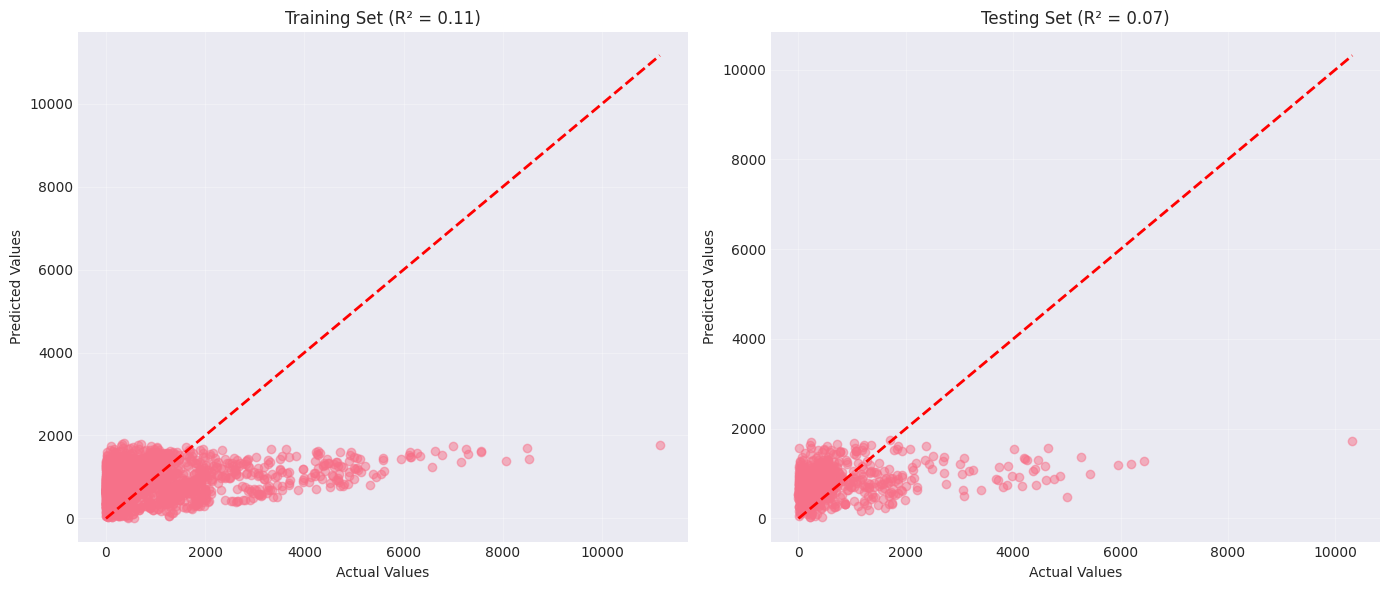


=== RESIDUAL ANALYSIS ===


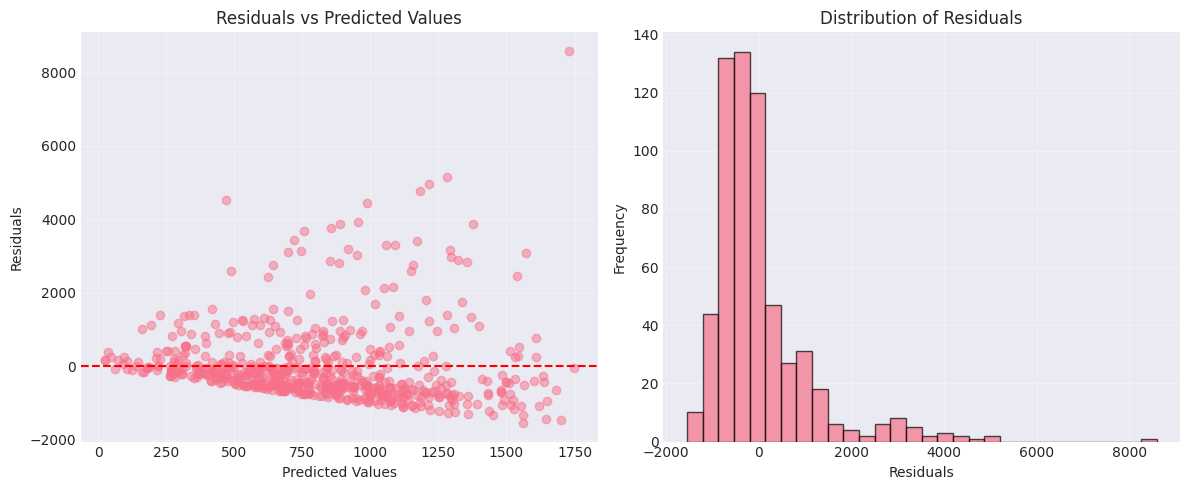

Residual mean: 21.46
Residual std: 1077.25


In [27]:
# Step 7.1: Calculate evaluation metrics
print("=== MODEL EVALUATION ===")

# Training set metrics
train_mse = mean_squared_error(y_train, y_pred_train)
train_rmse = np.sqrt(train_mse)
train_mae = mean_absolute_error(y_train, y_pred_train)
train_r2 = r2_score(y_train, y_pred_train)

# Testing set metrics
test_mse = mean_squared_error(y_test, y_pred_test)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print("\n=== TRAINING SET METRICS ===")
print(f"Mean Squared Error (MSE): {train_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {train_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {train_mae:.2f}")
print(f"R-squared Score: {train_r2:.2f}")

print("\n=== TESTING SET METRICS ===")
print(f"Mean Squared Error (MSE): {test_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {test_rmse:.2f}")
print(f"Mean Absolute Error (MAE): {test_mae:.2f}")
print(f"R-squared Score: {test_r2:.2f}")

# Step 7.2: Visualize predictions vs actual values
print("\n=== VISUALIZING PREDICTIONS ===")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
axes[0].scatter(y_train, y_pred_train, alpha=0.5)
axes[0].plot(
    [y_train.min(), y_train.max()], [y_train.min(), y_train.max()], "r--", lw=2
)
axes[0].set_xlabel("Actual Values")
axes[0].set_ylabel("Predicted Values")
axes[0].set_title(f"Training Set (R² = {train_r2:.2f})")
axes[0].grid(True, alpha=0.3)

# Testing set
axes[1].scatter(y_test, y_pred_test, alpha=0.5)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
axes[1].set_xlabel("Actual Values")
axes[1].set_ylabel("Predicted Values")
axes[1].set_title(f"Testing Set (R² = {test_r2:.2f})")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Step 7.3: Residual Analysis
print("\n=== RESIDUAL ANALYSIS ===")

residuals = y_test - y_pred_test

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_test, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Values")
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, edgecolor="black", alpha=0.7)
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check residual statistics
print(f"Residual mean: {residuals.mean():.2f}")
print(f"Residual std: {residuals.std():.2f}")


8. Feature Importance Analysis

=== FEATURE IMPORTANCE ANALYSIS ===

Feature Importance (sorted by absolute coefficient value):
                Feature  Coefficient
2  visitor_type_encoded   283.311482
0                  year   267.663043
6          covid_period  -206.835503
1       country_encoded   -40.460696
3                decade   -24.509425
4             post_2000   -14.076701
5             post_2010    -4.197869


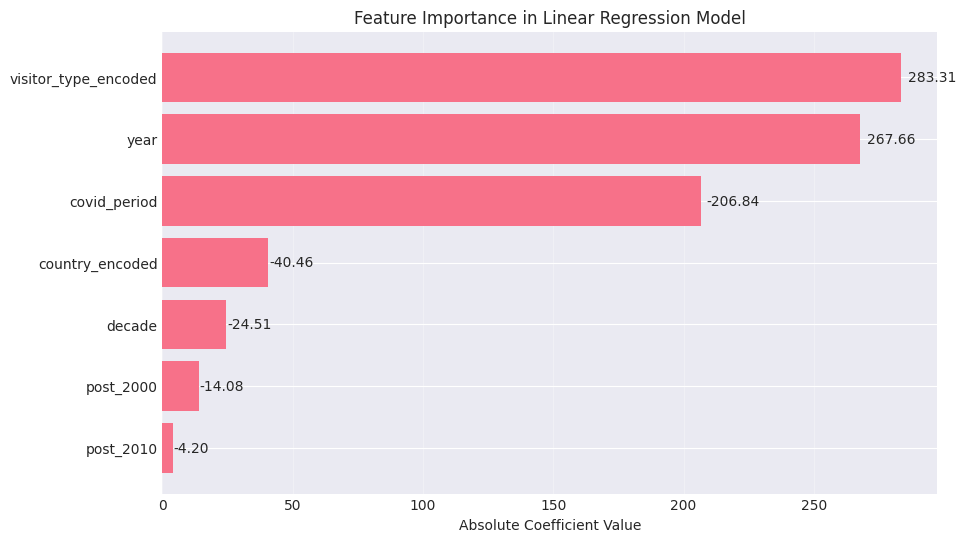

In [28]:
# Step 8.1: Analyze feature importance
print("=== FEATURE IMPORTANCE ANALYSIS ===")

# Create a DataFrame with feature names and coefficients
feature_importance = pd.DataFrame({"Feature": X.columns, "Coefficient": model.coef_})

# Sort by absolute value of coefficients
feature_importance["Abs_Coefficient"] = np.abs(feature_importance["Coefficient"])
feature_importance = feature_importance.sort_values("Abs_Coefficient", ascending=False)

print("\nFeature Importance (sorted by absolute coefficient value):")
print(feature_importance[["Feature", "Coefficient"]])

# Visualize feature importance
plt.figure(figsize=(10, 6))
bars = plt.barh(feature_importance["Feature"], feature_importance["Abs_Coefficient"])
plt.xlabel("Absolute Coefficient Value")
plt.title("Feature Importance in Linear Regression Model")
plt.gca().invert_yaxis()  # Highest importance at top
plt.grid(True, alpha=0.3, axis="x")

# Add coefficient values on bars
for bar, coeff in zip(bars, feature_importance["Coefficient"]):
    plt.text(
        bar.get_width() * 1.01,
        bar.get_y() + bar.get_height() / 2,
        f"{coeff:.2f}",
        va="center",
    )

plt.show()


9. Making Predictions on New Data


In [ ]:
# Step 9.1: Create a prediction function
print("=== MAKING PREDICTIONS ===")


def predict_tourist_numbers(year, country_name, visitor_type):
    """
    Predict number of tourists for given parameters

    Parameters:
    year: int (e.g., 2026)
    country_name: str (e.g., 'Bahamas')
    visitor_type: str (e.g., 'tourists', 'excursionists', 'visitors_total')
    """
    try:
        # Encode inputs
        country_code = country_encoder.transform([country_name])[0]
        visitor_code = visitor_type_encoder.transform([visitor_type])[0]

        # Calculate derived features
        decade = (year // 10) * 10
        post_2000 = 1 if year > 2000 else 0
        post_2010 = 1 if year > 2010 else 0
        covid_period = 1 if year >= 2020 and year <= 2021 else 0

        # Create feature array
        features = np.array(
            [
                [
                    year,
                    country_code,
                    visitor_code,
                    decade,
                    post_2000,
                    post_2010,
                    covid_period,
                ]
            ]
        )

        # Scale features
        features_scaled = scaler.transform(features)

        # Make prediction
        prediction = model.predict(features_scaled)[0]

        return max(prediction, 0)  # Ensure non-negative prediction

    except Exception as e:
        return f"Error: {str(e)}"


# Step 9.2: Test predictions with examples
print("\n=== EXAMPLE PREDICTIONS ===")

# Example 1
pred1 = predict_tourist_numbers(2028, "Bahamas", "tourists")    
print(f"Predicted tourists for Bahamas in 2028: {pred1:.0f} thousand trips")

# Example 2
pred2 = predict_tourist_numbers(2027, "Dominican Republic", "visitors_total")
print(
    f"Predicted total visitors for Dominican Republic in 2027: {pred2:.0f} thousand trips"
)

# Example 3
pred3 = predict_tourist_numbers(2026, "Jamaica", "excursionists")
print(f"Predicted excursionists for Jamaica in 2026: {pred3:.0f} thousand trips")


=== MAKING PREDICTIONS ===

=== EXAMPLE PREDICTIONS ===
Predicted tourists for Bahamas in 2028: 1604 thousand trips
Predicted total visitors for Dominican Republic in 2027: 1864 thousand trips
Predicted excursionists for Jamaica in 2026: 1129 thousand trips


10. Model Interpretation and Summary

In [ ]:
# Step 10.1: Provide model interpretation
print("=== MODEL INTERPRETATION ===")
print("\n1. MODEL PERFORMANCE:")
print(
    f"   - The model explains approximately {test_r2 * 100:.1f}% of variance in tourist numbers"
)
print(f"   - Average prediction error (RMSE): {test_rmse:.0f} thousand trips")
print(f"   - Average absolute error (MAE): {test_mae:.0f} thousand trips")

print("\n2. KEY FINDINGS:")
print("   - Year has a significant impact on tourist numbers")
print("   - Country and visitor type are important predictors")
print("   - COVID-19 period indicator helps capture pandemic effects")

print("\n3. MODEL LIMITATIONS:")
print("   - Linear model may not capture complex non-linear relationships")
print("   - Model doesn't account for economic factors or events")
print("   - Predictions for extreme years may be less accurate")

print("\n4. RECOMMENDATIONS FOR IMPROVEMENT:")
print("   - Add more features (GDP, flight availability, marketing budget)")
print("   - Try polynomial regression for non-linear relationships")
print("   - Use time series models (ARIMA, Prophet) for temporal patterns")
print("   - Implement ensemble methods (Random Forest, Gradient Boosting)")

# Step 10.2: Save the model (optional)
print("\n=== SAVING MODEL ARTIFACTS ===")



# Create directory for model artifacts
os.makedirs("model_artifacts", exist_ok=True)

# Save model and preprocessing objects
joblib.dump(model, "model_artifacts/linear_regression_model.pkl")
joblib.dump(scaler, "model_artifacts/scaler.pkl")
joblib.dump(country_encoder, "model_artifacts/country_encoder.pkl")
joblib.dump(visitor_type_encoder, "model_artifacts/visitor_type_encoder.pkl")

# Save feature importance
feature_importance.to_csv("model_artifacts/feature_importance.csv", index=False)

print("Model artifacts saved to 'model_artifacts/' directory")


=== MODEL INTERPRETATION ===

1. MODEL PERFORMANCE:
   - The model explains approximately 7.1% of variance in tourist numbers
   - Average prediction error (RMSE): 1077 thousand trips
   - Average absolute error (MAE): 701 thousand trips

2. KEY FINDINGS:
   - Year has a significant impact on tourist numbers
   - Country and visitor type are important predictors
   - COVID-19 period indicator helps capture pandemic effects

3. MODEL LIMITATIONS:
   - Linear model may not capture complex non-linear relationships
   - Model doesn't account for economic factors or events
   - Predictions for extreme years may be less accurate

4. RECOMMENDATIONS FOR IMPROVEMENT:
   - Add more features (GDP, flight availability, marketing budget)
   - Try polynomial regression for non-linear relationships
   - Use time series models (ARIMA, Prophet) for temporal patterns
   - Implement ensemble methods (Random Forest, Gradient Boosting)

=== SAVING MODEL ARTIFACTS ===
Model artifacts saved to 'model_artifa